In [1]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from __future__ import division, print_function, absolute_import
import numpy as np
import tensorflow as tf
import h5py
import glob
import sys, os
from NetworkSwitch import *
from sklearn.preprocessing import scale
from skimage.util import view_as_windows as vaw
from numpy import random as npr
from scipy.misc import imresize

In [2]:
# define useful variables
os.chdir('/home/TF_Rover/RoverData/Right2')
fnames = glob.glob('*.h5') # datasets to train on
iters = 500 # number of training iterations
batch_sz = 100  # training batch size
f_int = 5
f_int2 = 15
num_stack = 1
patch_sz = 15
val_name = 'Run_218seconds_Michael_Sheri.h5' # Dataset to use for validation
imsz = 100
D = {} # dictionary to hold learned dictionaries
A = {} # dictionary to hold sparse coefficients
E = {} # dictionary to hold error rates

In [3]:
def create_framestack(x, y, f_int, f_int2):
    X_ = []
    Y_ = []
    for ex_num in range(x.shape[0]-1, f_int2, -1):
        X2 = x[ex_num-f_int, :, :, :]
        X3 = x[ex_num-f_int2, :, :, :]
        X_.append(np.concatenate((x[ex_num, :, :, :], X2, X3), 2))
        Y_.append(y[ex_num, :])
    return np.asarray(X_), np.asarray(Y_)

In [4]:
def whiten(X):
    '''Function to ZCA whiten image matrix.'''
    
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return np.dot(ZCAMatrix, X)

In [5]:
def get_patches(X, ps):
    X = vaw(X, (1, ps, ps))
    subsample = np.int32(ps/2+1)
    X = X[::20, ::subsample, ::subsample, ...]
    num_patches = X.shape[0]*X.shape[1]*X.shape[2]*X.shape[3]
    return np.transpose(X.reshape([num_patches, -1]))

In [6]:
def plot2(a, e):
    # plot a histogram of the sparse coefficients 
    # and the error rate over time
    fig = plt.figure()
    a1 = fig.add_subplot(121)
    a1.plot(e[1:, 0])
    a1.set_ylabel('l2 error')
    a1.set_xlabel('Iteration')
    a2 = fig.add_subplot(122)
    a2.hist(a)
    a2.set_ylabel('Number of coefficients')
    a2.set_xlabel('Activation')
    plt.show()
    return

In [7]:
def mat2ten(X):
    zs=[X.shape[1], int(np.sqrt(X.shape[0])), int(np.sqrt(X.shape[0]))]
    Z=np.zeros(zs)
    
    for i in range(X.shape[1]):
        Z[i, ...]=np.reshape(X[:,i],[zs[1],zs[2]])
        
    return Z

In [8]:
def montage(X):    
    count, m, n = np.shape(X)    
    mm = int(np.ceil(np.sqrt(count)))
    nn = mm
    M = np.zeros((mm * m, nn * n))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count: 
                break
            sliceM, sliceN = j * m, k * n
            M[sliceN:sliceN + n, sliceM:sliceM + m] = X[image_id, ...]
            image_id += 1
    return M

In [9]:
def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap='gray')
    ax.axis('off')
    fig.set_size_inches(18, 10)
    plt.show()

In [10]:
def file_get(filename):
    f = h5py.File(filename, 'r')
    X = np.asarray(f['X'])
    f.flush()
    f.close()
    return np.mean(X, 3)

In [11]:
def resize_images(X, newsize):
    x = []
    
    for i in range(X.shape[0]):
        x.append(imresize(X[i, ...], [newsize, newsize]))
        
    return np.asarray(x)

In [12]:
print('Validation Dataset: %s'%(val_name))

Validation Dataset: Run_218seconds_Michael_Sheri.h5


(100, 2560)


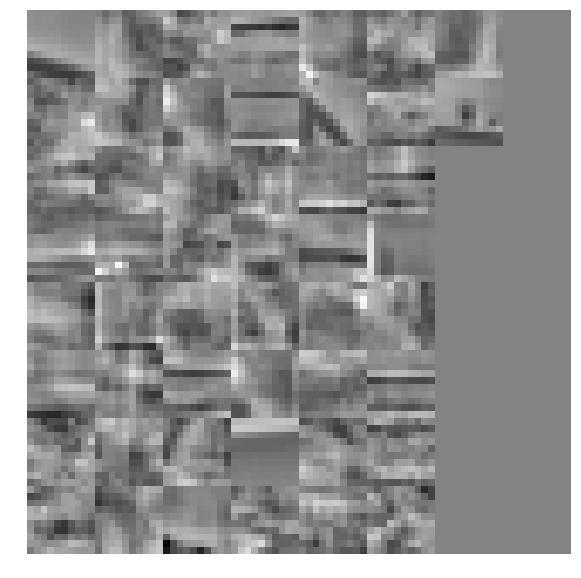

[-7.09483555 -6.93644232 -6.87985423 ...,  6.5703843   6.80365427
  6.90460211]


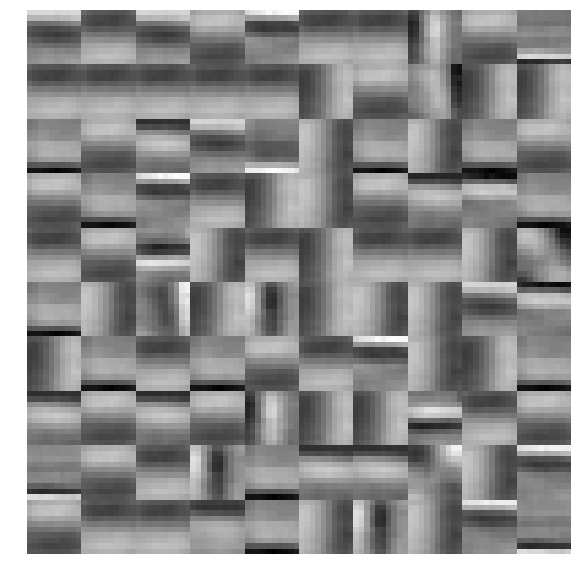

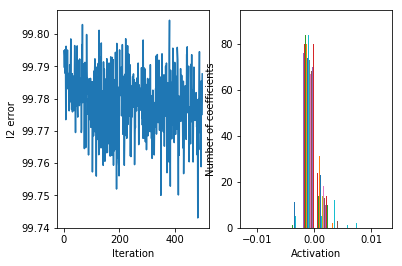

(100, 2560)


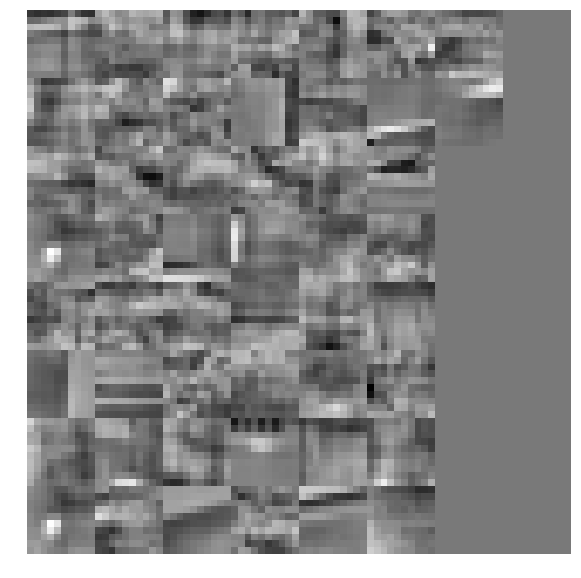

[-8.52077381 -7.04018896 -6.5269828  ...,  6.44090975  7.02969591
  7.28714931]


KeyboardInterrupt: 

In [13]:
with tf.Session() as sess:

    for k in range(100, 1001, 100):

        # pick random dataset for this epoch
        n = np.random.randint(1, len(fnames)-1, 1)
        filename = fnames[n[0]]
    
        # skip validation set if chosen
        #if filename == val_name: 
        #    continue

        # load the chosen data file
        X = file_get(filename)

        # make the images smaller
        X = resize_images(X, imsz)

        # Choose 50 random images from the dataset
        X = X[npr.randint(0, X.shape[0], 200), ...]
        X = whiten(X.reshape([X.shape[0], -1])).reshape([200, imsz, imsz])

        # take patches out of the images 
        X = get_patches(X, patch_sz)
        print(X.shape)

        # scale the pixel values down to between 0 and 1
        X = scale(X, 0)
        
        # plot some of the patches
        plot(montage(mat2ten(X[:, npr.randint(0, X.shape[1], 50)])))
        print(np.unique(X))

        # name to save each dictionary and coefficients as 
        save_name = str(k) + '_' + str(patch_sz)

        # send data to network and get back dictionary and coefficients
        D[save_name], A[save_name], E[save_name] = X3(X,
                                                      iters,
                                                      batch_sz,
                                                      num_dict_features=k)

        # visualize the learned dictionary
        plot(montage(mat2ten(D[save_name])))
        
        e = E[save_name]
        
        plot2(A[save_name], e)